In [141]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm

from itertools import permutations
import sys

import numpy as np
np.warnings.filterwarnings('ignore')

In [130]:
"""
This file contains code for conditional entropy forests. 
Adapted from https://github.com/rguo123/conditional_entropy_forests/blob/master/code/algorithm.py
"""

def finite_sample_correction(class_probs, row_sums):
    
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
    where_1 = np.argwhere(class_probs == 1)
    for elem in where_1:
        class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
    return class_probs

def build_model(X, y, n_estimators=200, max_samples=.32,
                                            bootstrap=True,
                                            depth=30,
                                            min_samples_leaf=1):
    if X.ndim == 1:
        raise ValueError('1d data will cause headaches down the road')
        
    max_features = int(np.ceil(np.sqrt(X.shape[1])))
        
    model=BaggingClassifier(DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf,
                                                     max_features = max_features),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              bootstrap=bootstrap)
    
    model.fit(X, y)
    return model

def get_leaves(estimator):
    # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    
    leaf_ids = []
    stack = [(0, -1)] 
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_ids.append(node_id)
            
    return np.array(leaf_ids)

def estimate_posteriors(model, train, y, test, in_task=True, subsample=0, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    n, d = train.shape
    m, d_ = test.shape
    
    if d != d_:
        raise ValueError("train and test data in different dimensions")
    
    class_counts = np.zeros((m, model.n_classes_))
    for tree in model:
        # get out of bag indicies
        if in_task:
            prob_indices = _generate_unsampled_indices(tree.random_state, n)
            # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
        else:
            if subsample:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)
            else:
                prob_indices = range(n)
        
        leaf_nodes = get_leaves(tree)
        unique_leaf_nodes = np.unique(leaf_nodes)
            
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(unique_leaf_nodes), model.n_classes_))

        for prob_index in prob_indices:
            temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
            posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1
            
        # total number of points in a node
        row_sums = posterior_class_counts.sum(axis=1)
        
        # no divide by zero
        row_sums[row_sums == 0] = 1

        # posteriors
        class_probs = (posterior_class_counts / row_sums[:, None])
        # posteriors with finite sampling correction
        
        class_probs = finite_sample_correction(class_probs, row_sums)
    
        # posteriors as a list
        class_probs.tolist()
        
        partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts / class_counts.sum(axis=1, keepdims=True)
    
    return probs

def predict(a):
    return np.argmax(a, axis = 1)

def permutation(predict1, predict2, force=False):
    """
    how to use:
    
    this function returns the permutation i.e. \pi: [K] -> [K] that maximizes
    the number of matched predictions
    
    to use the permutation for posteriors for point i (posterior_i), say, simply use
    posterior_i[permutation]
    
    """
    unique_1 = np.unique(predict1)
    unique_2 = np.unique(predict2)
    
    if force:
        for i, u in enumerate(unique_1):
            if u not in unique_2:
                unique_2 = np.concatenate((unique_2, [u]))
        
        for i, u in enumerate(unique_2):
            if u not in unique_1:
                unique_1 = np.concatenate((unique_1, [u]))
    else:
        if set(unique_1) != set(unique_2):
            raise ValueError("predictions must be on the same set of labels")
        
    K = len(unique_1)
    
    max_sum = 0
    max_perm = unique_2
    for i, perm in enumerate(permutations(unique_2)):
        perm = np.array(list(perm))
        temp_predict2 = -1*np.ones(len(predict2))
        
        for k in range(K):
            temp_predict2[np.where(predict2 == unique_2[k])[0]] = perm[k]
           
        temp_sum = np.sum(predict1 == temp_predict2)
        if temp_sum > max_sum:
            max_sum = temp_sum
            max_perm = perm
            
    return max_perm
            
def estimate_alpha(predict1, predict2, permutation=None):
    if permutation is None:
        return np.sum(predict1 == predict2) / len(predict1)
    else:
        unique = np.unique(temp_predict2)
        temp_predict2 = -1*np.ones(len(predict2))
        
        for i, k in enumerate(unique):
            temp_predict2[predict2 == k] = permutation[i]
            
        return np.sum(predict1 == temp_predict2) / len(predict1)
    
def generate_sample(n, pi, conditional_0, params0, conditional_1, params1, d = 2, acorn=None):
    if acorn is None:
        acorn = np.random.seed(10**6)
    np.random.seed(acorn)
    
    n0 = int(np.random.binomial(n, pi))
    n1 = n - n0
    ns = [n0, n1]
    
    X0 = conditional_0(*params0, size=(n0, d))
    
    X1 = conditional_1(*params1, size=(n1, d))
    
    labels = np.concatenate([i*np.ones(ns[i]) for i in range(len(ns))]).astype(int)
    
    return [np.concatenate((X0, X1), axis = 0), labels]

def generate_parity(n, d=2, invert_labels=False,acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    X = np.random.uniform(-1, 1, size=(n, d))
    Y = (np.sum(X > 0, axis=1) % 2 == 0).astype(int)
    
    if invert_labels:
        Y = -1 * (Y - 1)
    
    return X, Y.astype(int)

def parity_experiment(nx, nz, d, m, n_algos=6):
    Tx = int(np.floor(np.sqrt(nx)))
    Tz = int(np.floor(np.sqrt(nz)))
    
    Kx = int(np.floor(np.log(nx)))
    Kz = int(np.floor(np.log(nz)))
    
    errors = np.zeros(n_algos)
    
    temp_predictions = [[] for __ in range(n_algos)]
    
    # Sum
    Z, labelsZ = generate_parity(nz + nx, d, invert_labels=True)
    testZ, test_labelsZ = generate_parity(m, d, invert_labels=True)
    
    model_best = build_model(Z, labelsZ, int(np.floor(np.sqrt(nx + nz))))
    
    posteriors_best=estimate_posteriors(model_best, Z, labelsZ, testZ, in_task=True)
    predictions_best=predict(posteriors_best)
    
    errors[-1] = 1 - np.sum(test_labelsZ == predictions_best)/m

    # Source task
    X, labelsX = generate_parity(nx, d)
    testX, test_labelsX = generate_parity(m, d)

    
    # Target task
    Z, labelsZ = generate_parity(nz, d, invert_labels=True)
    testZ, test_labelsZ = generate_parity(m, d, invert_labels=True)


    model_X = build_model(X, labelsX, Tx)
    model_Z = build_model(Z, labelsZ, Tz)

    posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, testX, in_task=True)
    posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, testX, in_task=False, subsample=1-0.32)

    pred_structX_estX=predict(posteriors_structX_estX)
    pred_structZ_estX=predict(posteriors_structZ_estX)

    posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, testZ, in_task=False, subsample=1-0.32)
    posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, testZ, in_task=True)
    
    pred_structX_estZ=predict(posteriors_structX_estZ)
    pred_structZ_estZ=predict(posteriors_structZ_estZ)

    # calculate errors without attempting to transfer knowledge
    pred_X = predict(posteriors_structX_estX)
    pred_Z = predict(posteriors_structZ_estZ)

    errors[0] = 1 - np.sum(test_labelsX == pred_X)/m
    errors[1] = 1 - np.sum(test_labelsZ == pred_Z)/m
    
    errors[2] = 1 - np.sum(test_labelsX == pred_structZ_estX)/m
    errors[3] = 1 - np.sum(test_labelsZ == pred_structX_estZ)/m
    
    

    # jtv ?
    pred_X_jtv = predict(posteriors_structX_estX + posteriors_structZ_estX)
    pred_Z_jtv = predict(posteriors_structZ_estZ + posteriors_structX_estZ)

    errors[4] = 1 - np.sum(test_labelsX == pred_X_jtv)/m
    errors[5] = 1 - np.sum(test_labelsZ == pred_Z_jtv)/m
    
    # now using local estimates..
    new_posteriors_structX_estZ_local = np.zeros(posteriors_structX_estZ.shape)
    new_posteriors_structZ_estX_local = np.zeros(posteriors_structZ_estX.shape)

    kNN_X = NearestNeighbors(n_neighbors=Kx).fit(testX)    
    kNN_Z = NearestNeighbors(n_neighbors=Kz).fit(testZ)

    alpha_X_local = np.zeros(m)
    for k, obs in enumerate(testX):
        obs = obs.reshape(1, -1)
        temp_neighbors = kNN_X.kneighbors(obs)[1]

        temp_preds_structX_estX = pred_structX_estX[temp_neighbors]
        temp_preds_structZ_estX = pred_structZ_estX[temp_neighbors]

        temp_permutation = permutation(temp_preds_structX_estX, temp_preds_structZ_estX, force=True)

        pred_structZ_estX_local = predict(new_posteriors_structZ_estX_local)

        alpha_X_local[k] = estimate_alpha(pred_structZ_estX_local, pred_structX_estX)
        new_posteriors_structZ_estX_local[k] = alpha_X_local[k]*posteriors_structZ_estX[k][temp_permutation]

    alpha_Z_local = np.zeros(m)
    for k, obs in enumerate(testZ):
        obs = obs.reshape(1, -1)
        temp_neighbors = kNN_Z.kneighbors(obs)[1]

        temp_preds_structX_estZ = pred_structX_estZ[temp_neighbors]
        temp_preds_structZ_estZ = pred_structZ_estZ[temp_neighbors]

        temp_permutation = permutation(temp_preds_structX_estZ, temp_preds_structZ_estZ, force=True)
        pred_structX_estZ_local = predict(new_posteriors_structX_estZ_local)

        alpha_Z_local[k] = estimate_alpha(pred_structZ_estZ, pred_structX_estZ_local)
        new_posteriors_structX_estZ_local[k] = alpha_Z_local[k]*posteriors_structX_estZ[k][temp_permutation]

    pred_X_cep_local = predict(posteriors_structX_estX +  new_posteriors_structZ_estX_local)
    pred_Z_cep_local = predict(posteriors_structZ_estZ + new_posteriors_structX_estZ_local)

    
    print("X:" + str(pred_X_cep_local))
    errors[6] = 1 - np.sum(test_labelsX == pred_X_cep_local)/m
    print("Z:" + str(pred_Z_cep_local))
    errors[7] = 1 - np.sum(test_labelsZ == pred_Z_cep_local)/m

    return errors

In [160]:
def jovo_experiment(nx, nz, d, m, target="Z", subsample = 0.32, n_algos=6):
    if target == "Z":
        invert_z = True
        invert_x = False
    else:
        invert_z = False
        invert_x = True
        
    Tx = int(np.floor(np.sqrt(nx)))
    Tz = int(np.floor(np.sqrt(nz)))
    
    Kx = int(np.floor(np.log(nx)))
    Kz = int(np.floor(np.log(nz)))
    
    errors = np.zeros(n_algos)
        
    # Sum
    Z, labelsZ = generate_parity(nz + nx, d, invert_labels=invert_z)
    testZ, test_labelsZ = generate_parity(m, d, invert_labels=invert_z)
    
    model_best = build_model(Z, labelsZ, int(np.floor(np.sqrt(nx + nz))))
    
    posteriors_best=estimate_posteriors(model_best, Z, labelsZ, testZ, in_task=True)
    predictions_best=predict(posteriors_best)
    
    errors[-1] = 1 - np.sum(test_labelsZ == predictions_best)/m

    # Source task
    X, labelsX = generate_parity(nx, d, invert_labels=invert_x)
    testX, test_labelsX = generate_parity(m, d, invert_labels=invert_x)

    
    # Target task
    Z, labelsZ = generate_parity(nz, d, invert_labels=invert_z)
    testZ, test_labelsZ = generate_parity(m, d, invert_labels=invert_z)


    model_X = build_model(X, labelsX, Tx)
    model_Z = build_model(Z, labelsZ, Tz)

    posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, testX, in_task=True)
    posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, testX, in_task=False, subsample=subsample)

    pred_structX_estX=predict(posteriors_structX_estX)
    pred_structZ_estX=predict(posteriors_structZ_estX)

    posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, testZ, in_task=False, subsample=subsample)
    posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, testZ, in_task=True)
    
    pred_structX_estZ=predict(posteriors_structX_estZ)
    pred_structZ_estZ=predict(posteriors_structZ_estZ)

    # calculate errors without attempting to transfer knowledge
    pred_X = predict(posteriors_structX_estX)
    pred_Z = predict(posteriors_structZ_estZ)

    errors[0] = 1 - np.sum(test_labelsX == pred_X)/m
    errors[3] = 1 - np.sum(test_labelsZ == pred_Z)/m
    
    errors[1] = 1 - np.sum(test_labelsX == pred_structZ_estX)/m
    errors[4] = 1 - np.sum(test_labelsZ == pred_structX_estZ)/m

    # jtv ?
    pred_X_jtv = predict(posteriors_structX_estX + posteriors_structZ_estX)
    pred_Z_jtv = predict(posteriors_structZ_estZ + posteriors_structX_estZ)

    errors[2] = 1 - np.sum(test_labelsX == pred_X_jtv)/m
    errors[5] = 1 - np.sum(test_labelsZ == pred_Z_jtv)/m

    return errors

In [161]:
from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 100 # number of simulation repititions
# ns0 = (10*np.arange(3,5,step=1)).astype(int)
ns1 = (100*np.arange(1, 4, step=0.5)).astype(int) # number of training samples 
# ns = np.concatenate((ns0, ns1))
ns = ns1
nz_prop = 1

m = 100 # number of test samples each monte carlo iteration

algorithms = ['Lpp', 'Lqp', 'p L2M', 'Lqq', 'Lpq', 'q L2M']
# algorithms = np.concatenate((algorithms, ['task1 cep local', 'task2 cep local'])) #, 'task1 jtv', 'task2 jtv']))
algorithms = np.concatenate((algorithms, ['L_{q}(n1 + n2)']))
M = len(algorithms)

mean_error = np.zeros((M, len(ns)))
std_error = np.zeros((M, len(ns)))

d = 3
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : jovo_experiment(100, x, d, m, target="Z", n_algos=M)
    
    errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_error[:, j] = np.mean(errors, axis=0)
    std_error[:, j] = np.std(errors, ddof=1, axis=0)

100%|██████████| 6/6 [00:12<00:00,  2.18s/it]


Text(0.5, 1.0, 'source=parity (p), target=not_parity (q), n1=100, d=3')

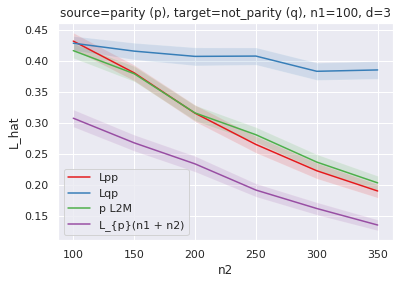

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mc_it = mc_its

sns.set()
colors = sns.color_palette("Set1", n_colors = M)
fig, ax = plt.subplots(1,1)
    
algo_offset=3
for i, algo in enumerate(algorithms[algo_offset:]):
    ax.plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i])
    ax.fill_between(ns, 
            mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
ax.legend()
ax.set_xlabel('n2')
ax.set_ylabel('L_hat')

ax.set_title('source=parity (p), target=not_parity (q), n1=100, d=%i'%(d))
# plt.savefig('parity_not_parity_n100%id.png'%(d))

In [163]:
from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 100 # number of simulation repititions
# ns0 = (10*np.arange(3,5,step=1)).astype(int)
ns1 = (100*np.arange(1, 4, step=0.5)).astype(int) # number of training samples 
# ns = np.concatenate((ns0, ns1))
ns = ns1
nz_prop = 1

m = 100 # number of test samples each monte carlo iteration

algorithms = ['Lqq', 'Lpq', 'taskq L2M', 'Lpp', 'Lqp', 'p L2M']
# algorithms = np.concatenate((algorithms, ['task1 cep local', 'task2 cep local'])) #, 'task1 jtv', 'task2 jtv']))
algorithms = np.concatenate((algorithms, ['L_{p}(n1 + n2)']))
M = len(algorithms)

mean_error_p = np.zeros((M, len(ns)))
std_error_p = np.zeros((M, len(ns)))

d = 3
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : jovo_experiment(100, x, d, m, target="X", n_algos=M)
    
    errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_error_p[:, j] = np.mean(errors, axis=0)
    std_error_p[:, j] = np.std(errors, ddof=1, axis=0)

100%|██████████| 6/6 [00:09<00:00,  1.77s/it]


AttributeError: module 'matplotlib.pyplot' has no attribute 'save_fig'

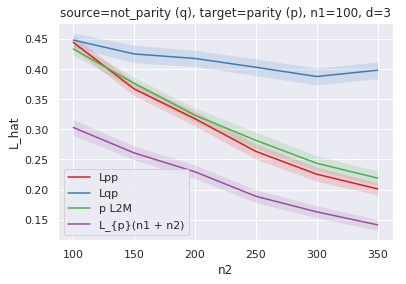

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mc_it = mc_its

sns.set()
colors = sns.color_palette("Set1", n_colors = M)
fig, ax = plt.subplots(1,1)
    
algo_offset=3
for i, algo in enumerate(algorithms[algo_offset:]):
    ax.plot(ns, mean_error_p[i + algo_offset], label=algo, c=colors[i])
    ax.fill_between(ns, 
            mean_error_p[i + algo_offset] + 1.96*std_error_p[i + algo_offset]/np.sqrt(mc_it), 
            mean_error_p[i + algo_offset] - 1.96*std_error_p[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_error_p[i + algo_offset] + 1.96*std_error_p[i + algo_offset]/np.sqrt(mc_it) >= mean_error_p[i + algo_offset] - 1.96*std_error_p[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
ax.legend()
ax.set_xlabel('n2')
ax.set_ylabel('L_hat')

ax.set_title('source=not_parity (q), target=parity (p), n1=100, d=%i'%(d))
plt.save_fig('temp_plot_p.png')

In [140]:
from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 100 # number of simulation repititions
# ns0 = (10*np.arange(3,5,step=1)).astype(int)
ns1 = (100*np.arange(1, 4, step=0.5)).astype(int) # number of training samples 
# ns = np.concatenate((ns0, ns1))
ns = ns1
nz_prop = 1

m = 100 # number of test samples each monte carlo iteration

algorithms = ['source', 'target', 'struct2_est1', 'struct1_est2', 'task1 L2M', 'task2 L2M']
# algorithms = np.concatenate((algorithms, ['task1 cep local', 'task2 cep local'])) #, 'task1 jtv', 'task2 jtv']))
algorithms = np.concatenate((algorithms, ['n1 + n2']))
M = len(algorithms)

mean_error = np.zeros((M, len(ns)))
std_error = np.zeros((M, len(ns)))

d = 3
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : parity_experiment(100, x, d, m, n_algos=M)
    
    errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_error[:, j] = np.mean(errors, axis=0)
    std_error[:, j] = np.std(errors, ddof=1, axis=0)

  0%|          | 0/6 [00:00<?, ?it/s]


IndexError: index 7 is out of bounds for axis 0 with size 7

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mc_it = mc_its

algo_offset = 0

sns.set()
colors = sns.color_palette("Set1", n_colors = M)
fig, ax = plt.subplots(1,1)
# for i, algo in enumerate(algorithms):
#     ax.plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i])
#     ax.fill_between(ns, 
#             mean_error[i] + 1.96*std_error[i]/np.sqrt(mc_it), 
#             mean_error[i] - 1.96*std_error[i]/np.sqrt(mc_it), 
#             where=mean_error[i] + 1.96*std_error[i]/np.sqrt(mc_it) >= mean_error[i] - 1.96*std_error[i]/np.sqrt(mc_it), 
#             facecolor=colors[i], 
#             alpha=0.15,
#             interpolate=True)
    
algo_offset=2
for i, algo in enumerate(algorithms[algo_offset:]):
    ax.plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i + algo_offset])
    ax.fill_between(ns, 
            mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i + algo_offset], 
            alpha=0.15,
            interpolate=True)
ax.legend()
ax.set_xlabel('n2')
ax.set_ylabel('L_hat')

ax.set_title('parity and not parity, n1=100, d=%i'%(d))
# plt.savefig('parity_not_parity_n100%id.png'%(d))

In [139]:
from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 100 # number of simulation repititions
ns = (100*np.arange(1, 8, step=0.5)).astype(int) # number of training samples 
nz_prop = 1

m = 100 # number of test samples each monte carlo iteration

algorithms = ['source', 'target', 'struct2_est1', 'struct1_est2', 'task1 L2M', 'task2 L2M']
# algorithms = np.concatenate((algorithms, ['task1 cep local', 'task2 cep local'])) #, 'task1 jtv', 'task2 jtv']))
algorithms = np.concatenate((algorithms, ['n1 + n2']))
M = len(algorithms)

mean_error = np.zeros((M, len(ns)))
std_error = np.zeros((M, len(ns)))

d = 3
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : parity_experiment(200, x, d, m, n_algos=M)
    
    errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_error[:, j] = np.mean(errors, axis=0)
    std_error[:, j] = np.std(errors, ddof=1, axis=0)

  0%|          | 0/14 [00:00<?, ?it/s]


IndexError: index 7 is out of bounds for axis 0 with size 7

Text(0.5, 1.0, 'parity and not parity, n1=200, d=3')

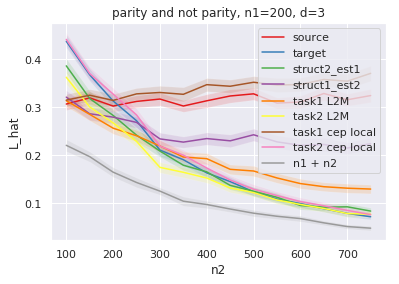

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mc_it = mc_its

algo_offset = 0

sns.set()
colors = sns.color_palette("Set1", n_colors = M)
fig, ax = plt.subplots(1,1)
for i, algo in enumerate(algorithms):
    ax.plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i])
    ax.fill_between(ns, 
            mean_error[i] + 1.96*std_error[i]/np.sqrt(mc_it), 
            mean_error[i] - 1.96*std_error[i]/np.sqrt(mc_it), 
            where=mean_error[i] + 1.96*std_error[i]/np.sqrt(mc_it) >= mean_error[i] - 1.96*std_error[i]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
    
# algo_offset=4
# for i, algo in enumerate(algorithms[algo_offset:algo_offset+2]):
#     ax.plot(2*ns, mean_error[i + algo_offset], label=algo, c=colors[i + algo_offset])
#     ax.fill_between(2*ns, 
#             mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
#             mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
#             where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
#             facecolor=colors[i + algo_offset], 
#             alpha=0.15,
#             interpolate=True)
ax.legend()
ax.set_xlabel('n2')
ax.set_ylabel('L_hat')

ax.set_title('parity and not parity, n1=200, d=%i'%(d))
# plt.savefig('parity_not_parity_n200%id.png'%(d))

In [ ]:
# cep global
pred_structX_estZ=predict(posteriors_structX_estZ)
pred_structZ_estZ=predict(posteriors_structZ_estZ)

optimal_permutation_X = permutation(pred_structX_estX, pred_structZ_estX)
optimal_permutation_Z = permutation(pred_structZ_estZ, pred_structX_estZ)

new_posteriors_structX_estZ = np.zeros(posteriors_structX_estZ.shape)
new_posteriors_structZ_estX = np.zeros(posteriors_structZ_estX.shape)
for k in range(m):
    new_posteriors_structX_estZ[k] = posteriors_structX_estZ[k][optimal_permutation_X]
    new_posteriors_structZ_estX[k] = posteriors_structZ_estX[k][optimal_permutation_Z]

pred_structX_estZ = predict(posteriors_structX_estZ)
pred_structZ_estX = predict(posteriors_structZ_estX)

alpha_X = estimate_alpha(pred_structX_estX, pred_structZ_estX)
alpha_Z = estimate_alpha(pred_structZ_estZ, pred_structX_estZ)

pred_X_cep_global = predict(posteriors_structX_estX + alpha_X * new_posteriors_structZ_estX)
pred_Z_cep_global = predict(posteriors_structZ_estZ + alpha_Z * new_posteriors_structX_estZ)

errors[4, i] = 1 - np.sum(test_labelsX == pred_X_cep_global)/m
errors[5, i] = 1 - np.sum(test_labelsZ == pred_Z_cep_global)/m

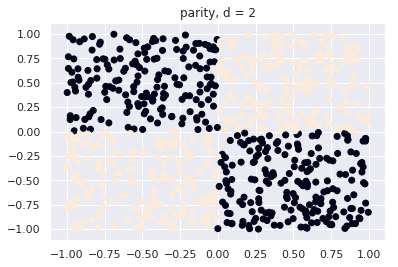

In [34]:
fig, ax = plt.subplots(1,1)
X, labelsX = generate_parity(n, 2)
Z, labelsZ = generate_parity(n, 2, invert_labels=True)

ax.scatter(X[:, 0], X[:, 1], c = labelsX)
ax.set_title("parity, d = 2")
plt.savefig('parity.png')

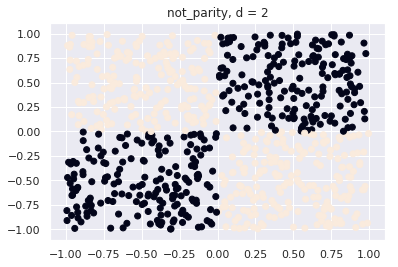

In [36]:
fig, ax = plt.subplots(1,1)
ax.scatter(Z[:, 0], Z[:, 1], c = labelsZ)
ax.set_title("not_parity, d = 2")
plt.savefig('not_parity.png')